In [14]:
import nibabel as nib
import numpy as np
from pathlib import Path
import glob

ModuleNotFoundError: No module named 'nilearn'

In [2]:
# Define paths
probtrack_dir = Path('probtrackx_output')
# Your subcortical seed mask - need to change to template mask
mask_file = '/home/m-ehara/project/diffparc-smk/results/diffparc/sub-PNC001/sub-PNC001_space-individual_label-fullBF_from-MNI152NLin6Asym_res-dwi_mask.nii.gz'  # Your subcortical seed mask
output_file = 'sub-PNC001_BF-Shcaefer400_connectome.npz'

In [3]:
# Load the subcortical mask
print("Loading subcortical mask...")
mask_nib = nib.load(mask_file)
mask_vol = mask_nib.get_fdata()
mask_indices = mask_vol > 0

Loading subcortical mask...


In [4]:
# Get number of voxels in the mask
nvoxels = mask_indices.sum()
print(f"Number of subcortical voxels: {nvoxels}")

Number of subcortical voxels: 4561


In [5]:
# Get all connectivity map files (seeds_to_*.nii.gz)
connmap_files = sorted(glob.glob(str(probtrack_dir / 'seeds_to_*.nii.gz')))
ntargets = len(connmap_files)
print(f"Number of cortical target ROIs: {ntargets}")

Number of cortical target ROIs: 0


In [6]:
# Initialize connectivity matrix: (nvoxels × ntargets)
conn = np.zeros((nvoxels, ntargets))

In [7]:
# Load each connectivity map and extract masked values
print("Extracting connectivity values...")
for i, conn_file in enumerate(connmap_files):
    if (i + 1) % 50 == 0:
        print(f"  Processing {i+1}/{ntargets}...")
    
    # Load connectivity volume for this target
    vol = nib.load(conn_file).get_fdata()
    
    # Extract values only for voxels in the mask
    masked = vol[mask_indices]
    
    # Store in connectivity matrix
    conn[:, i] = masked

print("Saving connectivity matrix...")
# Save as compressed .npz file
np.savez(output_file, 
         conn=conn,                # Connectivity matrix (nvoxels × ntargets)
         mask=mask_vol,            # Original mask volume
         affine=mask_nib.affine,   # Affine transformation matrix
         files=connmap_files)      # List of files for reference

print(f"Done! Connectivity matrix shape: {conn.shape}")
print(f"Saved to: {output_file}")

Extracting connectivity values...
Saving connectivity matrix...
Done! Connectivity matrix shape: (4561, 0)
Saved to: sub-PNC001_BF-Shcaefer400_connectome.npz


In [8]:
# Optional: Quick summary statistics
print("\nSummary statistics:")
print(f"  Mean connectivity: {conn.mean():.2f}")
print(f"  Max connectivity: {conn.max():.2f}")
print(f"  Non-zero connections: {(conn > 0).sum()} / {conn.size} ({100*(conn > 0).sum()/conn.size:.1f}%)")


Summary statistics:
  Mean connectivity: nan


/tmp/ipykernel_1168200/1880490264.py:3: RuntimeWarning: Mean of empty slice.
  print(f"  Mean connectivity: {conn.mean():.2f}")
/usr/local/fsl/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

In [9]:
# Load the connectivity matrix
data = np.load(output_file, allow_pickle=True)

conn = data['conn']        # (nvoxels × ntargets) connectivity matrix
mask = data['mask']        # 3D mask volume
affine = data['affine']    # Affine for spatial mapping
files = data['files']      # List of target files

print(f"Connectivity matrix: {conn.shape}")
print(f"Mask shape: {mask.shape}")

Connectivity matrix: (4561, 0)
Mask shape: (132, 132, 91)


/tmp/ipykernel_1168200/54412219.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(conn)


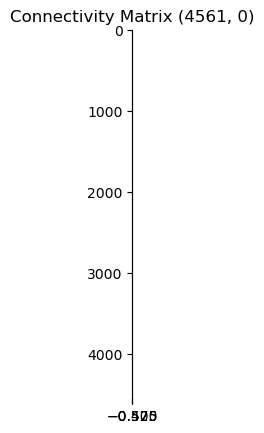

In [10]:
import matplotlib.pyplot as plt
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(conn)
ax.set_title('Connectivity Matrix {}'.format(conn.shape))
plt.show()

In [11]:
log_conn = np.log(conn)

/tmp/ipykernel_1168200/1513855177.py:2: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(log_conn)


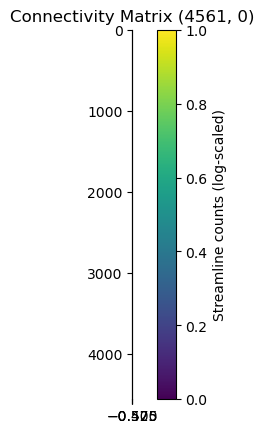

In [12]:
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(log_conn)
ax.set_title('Connectivity Matrix {}'.format(log_conn.shape))
cbar = plt.colorbar(im)
cbar.set_label("Streamline counts (log-scaled)")
plt.show()

/tmp/ipykernel_1168200/416375162.py:3: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(log_conn, aspect='auto', interpolation='nearest')


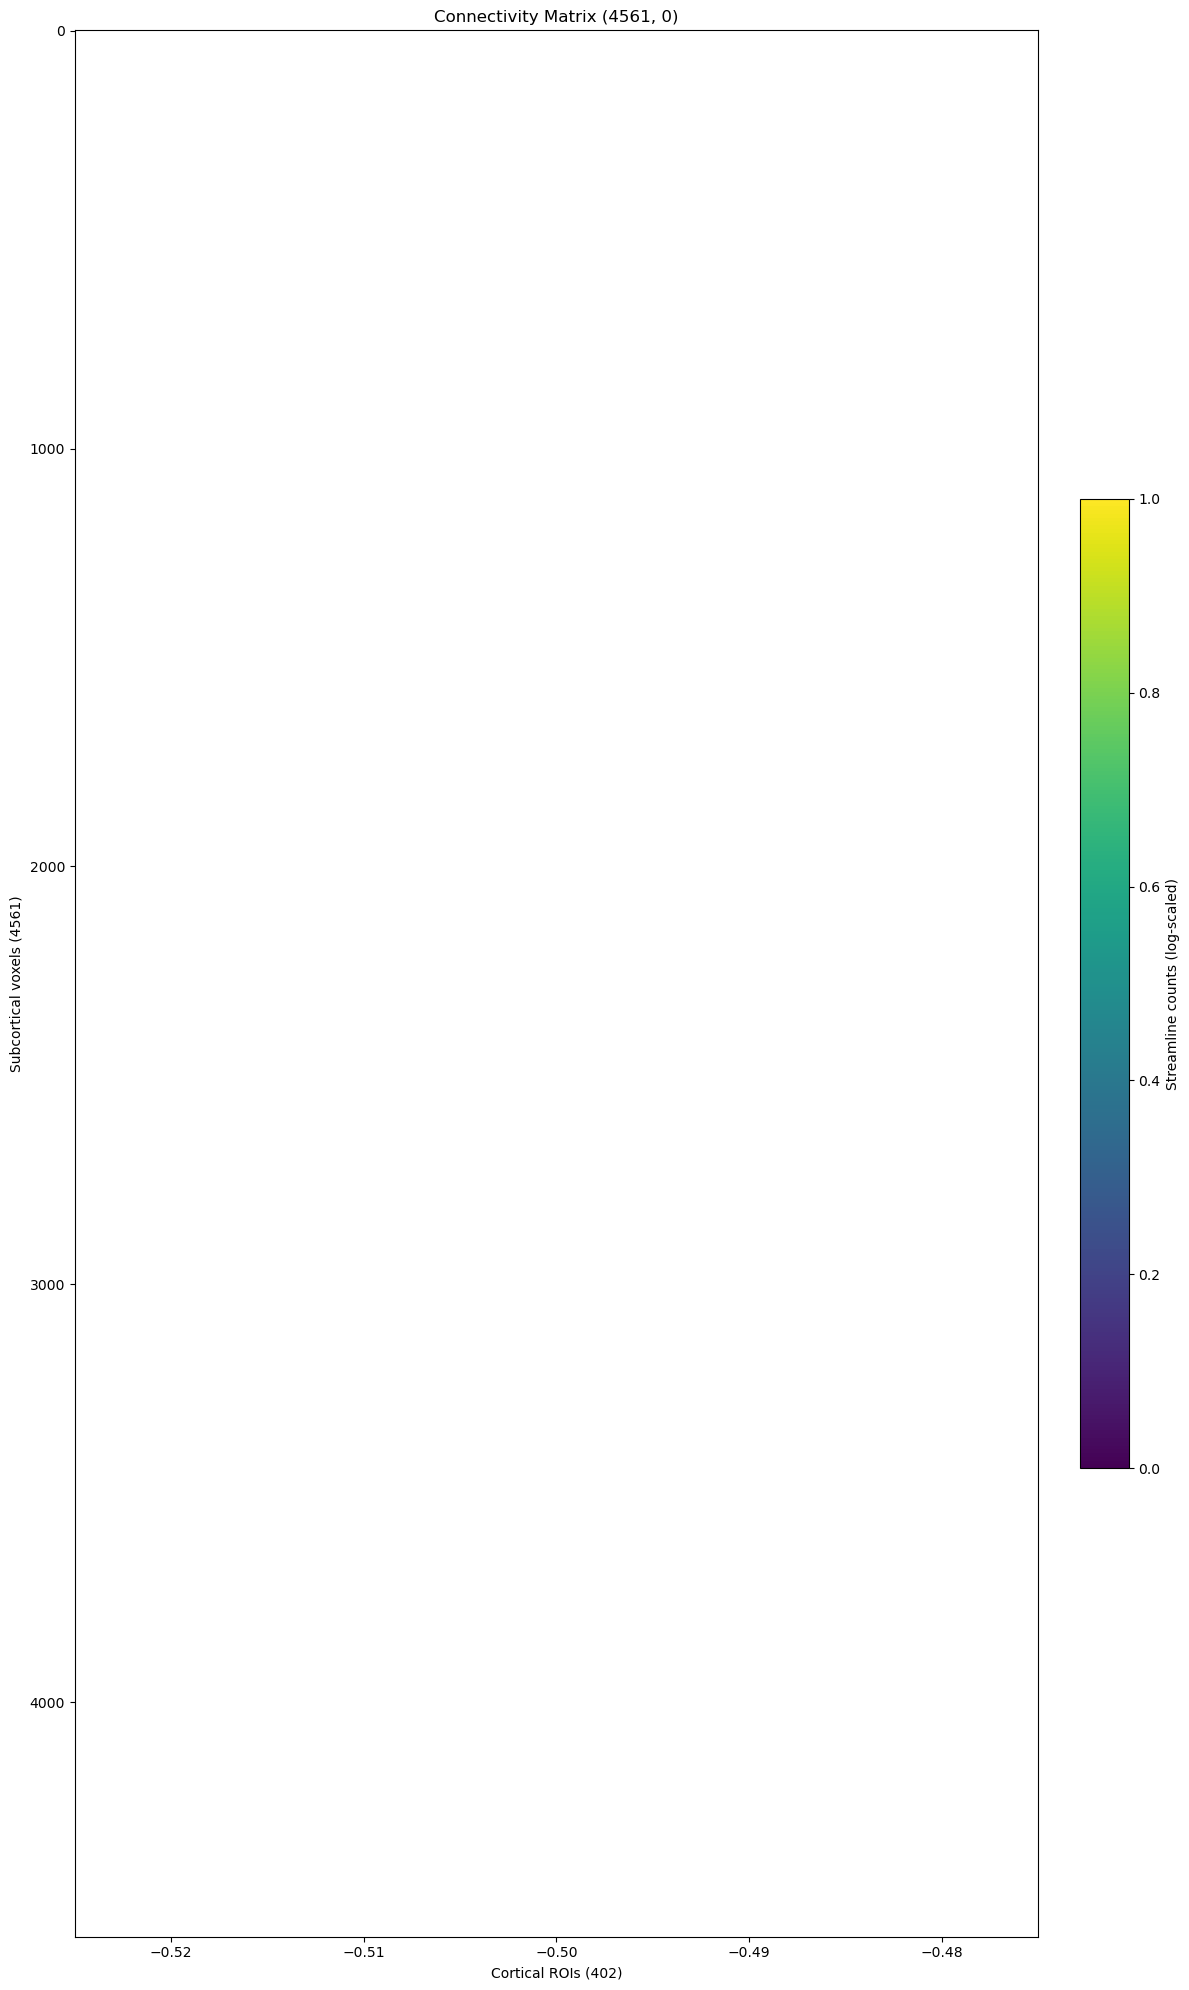

In [13]:
# Adjust figure size to better match your matrix dimensions
f, ax = plt.subplots(1, 1, figsize=(12, 20), dpi=100)  # Width x Height in inches
im = ax.imshow(log_conn, aspect='auto', interpolation='nearest')
ax.set_title('Connectivity Matrix {}'.format(log_conn.shape))
ax.set_xlabel('Cortical ROIs (402)')
ax.set_ylabel('Subcortical voxels (4561)')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Streamline counts (log-scaled)")
plt.tight_layout()
plt.show()